<a href="https://colab.research.google.com/github/sarthakkaushik/Cdiscount-Image-Classification/blob/main/Reading_Tfrecord_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code to mount google drive in case you are loading the data from your google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import os 
data_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount'
os.chdir(data_path)
print(os.getcwd())

/gdrive/MyDrive/UOH Assignment Dataset/cdiscount


In [28]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *
from tensorflow.python.data.experimental import AUTOTUNE
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../cdiscount"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

categories.csv
category_names.csv
file.h5
sample_submission.csv
test.bson
train.bson
train_example.bson
train_images.csv
train_offsets.csv
train_TFrecords.tfrecords
val_images.csv



In [29]:
#Reading Tfrecord file

data_dir = "../cdiscount/"

train_tfrecord_path = os.path.join(data_dir, "train_TFrecords.tfrecords")


raw_dataset = tf.data.TFRecordDataset(train_tfrecord_path)



In [30]:
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xfa6\n\x18\n\x0bcategory_id\x12\t\x1a\x07\n\x05\x9d\xe7\xeb\xdc\x03\n\x0f\n\x05width\x12\x06\x1a\x04\n\x02\xb4\x01\n\x956\n\x07img_raw\x12\x896\n\x866\n\x836\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xb4\x00\xb4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXY

In [31]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "category_id"
    value {
      int64_list {
        value: 1000010653
      }
    }
  }
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 180
      }
    }
  }
  feature {
    key: "img_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\000\264\000\264\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\00

In [32]:
def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'category_id':tf.io.FixedLenFeature([], tf.int64),      
      'product_id':tf.io.FixedLenFeature([], tf.int64),
      'img_raw' : tf.io.FixedLenFeature([], tf.string)
    }

    
  content = tf.io.parse_single_example(element, data)
  
  height = content['height']
  width = content['width']
  depth = content['depth']
  label = content['category_id']
  product_id = content['product_id']
  img_raw = content['img_raw']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  feature = tf.io.decode_raw(img_raw,tf.uint8,fixed_length=97200)
  feature = tf.reshape(feature, shape=[height,width,depth])
  return (feature, label)

To create a dataset out of the parse elements, we simply leverage the tf.data API. We create a TFRecordDataset by pointing it to the TFRecord file on our disk and then apply our previous parsing function to every extracted Example. This returns a dataset:

In [33]:
def get_dataset_small(filename):
  #create the dataset
  dataset = tf.data.TFRecordDataset(train_tfrecord_path, num_parallel_reads=4)
          # = tf.data.TFRecordDataset(train_tfrecord_path, compression_type = 'ZLIB')

  #pass every single feature through our mapping function
  dataset = dataset.map(
      parse_tfr_element, num_parallel_calls=AUTOTUNE
  )
    
  return dataset

We can explore the content of our dataset by taking a single data point:


In [19]:
dataset_small = get_dataset_small(train_tfrecord_path)

# for sample in dataset_small.take(1):
#   print(sample[0].shape)
#   print(sample[1].shape)

In [27]:
type(dataset_small)
dataset_small

<ParallelMapDataset shapes: ((None, None, None), ()), types: (tf.uint8, tf.int64)>

<class 'tensorflow.python.framework.ops.EagerTensor'>


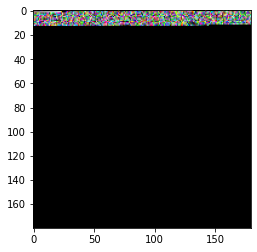

****************************************************************************************************
Shape- (180, 180, 3)
****************************************************************************************************
tf.Tensor(1000010653, shape=(), dtype=int64)
****************************************************************************************************
<class 'tensorflow.python.framework.ops.EagerTensor'>


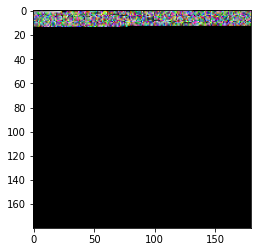

****************************************************************************************************
Shape- (180, 180, 3)
****************************************************************************************************
tf.Tensor(1000010653, shape=(), dtype=int64)
****************************************************************************************************
<class 'tensorflow.python.framework.ops.EagerTensor'>


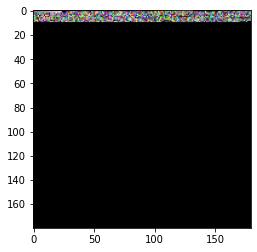

****************************************************************************************************
Shape- (180, 180, 3)
****************************************************************************************************
tf.Tensor(1000004079, shape=(), dtype=int64)
****************************************************************************************************
<class 'tensorflow.python.framework.ops.EagerTensor'>


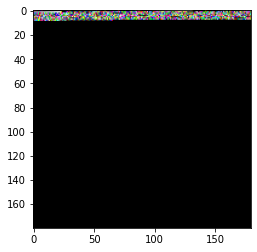

****************************************************************************************************
Shape- (180, 180, 3)
****************************************************************************************************
tf.Tensor(1000004141, shape=(), dtype=int64)
****************************************************************************************************
<class 'tensorflow.python.framework.ops.EagerTensor'>


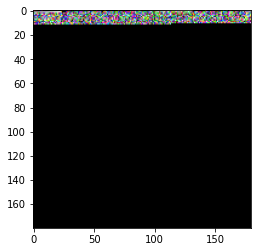

****************************************************************************************************
Shape- (180, 180, 3)
****************************************************************************************************
tf.Tensor(1000015539, shape=(), dtype=int64)
****************************************************************************************************


In [42]:
for data,l in dataset_small.take(5):
    print(type(data))
    arr_ = np.squeeze(data) # you can give axis attribute if you wanna squeeze in specific dimension
    plt.imshow(arr_.astype(np.uint8))
    plt.show()
    print("*"*100)

    print("Shape-",data.shape)
    print("*"*100)
    print(l)
    print("*"*100)


In [46]:
#Importing packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization,Dense, GlobalAveragePooling2D

num_classes = 5270

In [50]:
#-----------------------TRAINING------------------------------------------------#



model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# To train the model:
model.fit_generator(dataset_small,
                    steps_per_epoch = 10,   #num_train_images // batch_size,
                    epochs = 3
                    #num_val_images // batch_size,
                    )

# To evaluate on the validation set:
#model.evaluate_generator(val_gen, steps=num_val_images // batch_size, workers=8)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 22, 22, 128)     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


ValueError: ignored

FROM THE AUTHOR